# Introduction
This notebook contains a working example to show usage of the image perturbation and classifier-based saliency map generation API with the [Video and Image Analytics for Marine Environments (VIAME)](https://www.viametoolkit.org/) Toolkit.

We'll apply saliency maps to an underwater fish classification task (the data and models are publicly available on [viame.kitware.com](viame.kitware.com), but login or registration may be required). Using [VIAME](https://www.viametoolkit.org/), the trained fish detection and classification models can be used to assess the health and movement of different populations of fish in the ocean. To learn more about this ongoing work, please see the following [article](https://www.fisheries.noaa.gov/feature-story/science-snapper?fbclid=IwAR3gnTYiPbfdDVDD-LgBUSVc6XYv3Ia9SMerrySZkNx0lpRNB8NFAKF33RE).


We will create an application-like use-case where we transform an input image into a number of saliency heat-maps based on our black-box classifier's output, visualizing them over the input image.

This will necessarilly include the use of a classification model to perform the role of the black-box classifier that we will be determining the saliency for. We will make use of the [bioharn](https://gitlab.kitware.com/viame/bioharn) package for providing trained, deployable classification models in [PyTorch](https://pytorch.org/).

### Table of Contents
* [The test image](#The-test-image)
* [bioharn's ClfPredictor interface](#Black-box-Classifier)
* [Generating Saliency Maps](#Generating-Saliency-Maps)
    * [XAI Components](#XAI-Components)
    * [Creating and Calling an Application](#Calling-the-Application)

### Additional Python Requirements
The following additional python packages are required for this notebook besides the usual depedencies for `xaitk-saliency`:
- bioharn (tested with 0.2.0)
- jupyter
- torch (tested with 1.9.0)
- torchvision (tested with 0.10.0)

**Note**: To install v0.2.0 of bioharn, please use the following:
```
pip install git+https://gitlab.kitware.com/viame/bioharn.git@dev/0.2.0
```

### Miscellaneous
*Note*: When using the `from_config_dict` method below,
it is not unusual for the below code to throwback a warning
indicating missing psycopg2 and caffe modules.
Please disregard any such warnings.

Reference for implementation: Zeiler MD, Fergus R. Visualizing 
and understanding convolutional networks. InEuropean conference
on computer vision 2014 Sep 6 (pp. 818-833). Springer, Cham.

The test image is publicly available on [viame.kitware.com](viame.kitware.com) and freely provided by the [Southeast Fisheries Science Center (SEFSC)](https://www.fisheries.noaa.gov/about/southeast-fisheries-science-center).

# The test image
We will test this application on the following image, which contains a [red snapper](https://www.fisheries.noaa.gov/species/red-snapper), or "Lutjanus campechanus." Images in the dataset were run through a multi-stage pipeline involving fish detection and bounding box generation, followed by image chipping, and finally classification on the generated image chips. The image below shows a chipped image, which is subsequently passed through the trained fish classfication model.

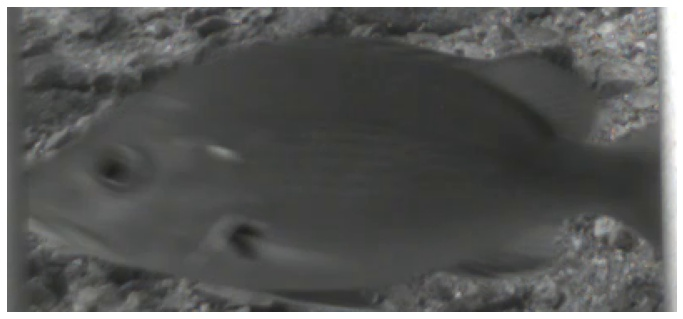

In [1]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


# We'll grab a publicly available chipped fish image
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1IsTUbnqj-QO4khQquwt9jAEwDIyFm5-f', "fish.png")
test_image_filename = 'fish.png'
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# Black-box Classifier
We will make use of [bioharn](https://gitlab.kitware.com/viame/bioharn), a PyTorch-based training and evaluation "harness" (or framework) catered towards biology related problems. Specifically, we will use the `ClfPredictor` interface, which allows for easy use of deployed model and configuration files at inference time.

In this example we will use a PyTorch-based ResNeXt101 model trained on fish classification data and use it's softmax output as classification confidences. Although there are ~100 different species or classes of fish, we will, for simplicity of example, constrain the output to the two classes that we happen to know are relevant for our test image.

In [2]:
import os
import tempfile
import urllib.request
import zipfile

# Let's first download some models...
# Note: this may take a while since this is about 5GB of data
temp_dir = tempfile.mkdtemp()
urllib.request.urlretrieve('https://viame.kitware.com/girder/api/v1/item/60b3a58b8438b3b7ffd7032f/download', os.path.join(temp_dir, "VIAME-SEFSC-Models.zip"))

# and then extract one of the models
zfile = zipfile.ZipFile(os.path.join(temp_dir, 'VIAME-SEFSC-Models.zip'))
zfile.extract('configs/pipelines/models/sefsc_species_resnext_big.zip', temp_dir)

In [3]:
from bioharn.clf_predict import ClfPredictor

# We make use of the automatic deployed model functionality in bioharn
config = {'deployed': os.path.join(temp_dir, 'configs/pipelines/models/sefsc_species_resnext_big.zip')}
predictor = ClfPredictor(config)

We'll set up our "black box" classifier using bioharn's `ClfPredictor` interface, pointing it to the deployed model file we downloaded above. For simplicility, we will constrain the output of our classifier here to the two classes that are relevant to our test image for the purposes of this example.

In [4]:
import numpy as np

# Get class names from the predictor model
predictor._ensure_model()
categories = predictor.coder.classes.class_names

# Choose some frequent fish classes
sal_class_labels = ['LUTJANUSCAMPECHANUS-170151107', 'LUTJANUSBUCCANELA-170151106']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]

def blackbox_classifier(test_image: PIL.Image.Image) -> np.ndarray:
    test_image_np = [np.array(t) for t in test_image]
    # Get class output probabilities
    preds = list(predictor.predict(test_image_np))
    # Only return the confidences for the focus classes
    class_conf = [p.prob[sal_class_idxs] for p in preds]
    return np.array(class_conf)

# Choose blackbox_fill value based on model input_norm
model_mean = predictor.model.input_norm.mean.cpu().numpy().flatten()
blackbox_fill = np.uint8(model_mean * 255)

Loading data onto None from <zopen(<_io.BufferedReader name='/tmp/tmp8l6c4y75/deploy_ClfModel_qgsxpjqj_028_GFSDLL/deploy_snapshot.pt'> mode=rb)>
Pretrained weights are a perfect fit


# Generating Saliency Maps

## XAI Components
Here we will setup our XAI components comprised of image perturbation and classifier-based saliency map generation.

We will start with the sliding-window perturbation method and the occlusion-based saliency map generation method.

We additionally construct a second perturber, RISE, that we can swap in and which will still function successfully due to API consistency, but with different results as per using a different algorithm.

In [5]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb
from xaitk_saliency.impls.perturb_image.rise import RISEPertubation
from xaitk_saliency.impls.vis_sal_classifier.occlusion_scoring import OcclusionScoring

perturber_slidingwindow = SlidingWindowPerturb((50, 50), (20, 20))
perturber_rise = RISEPertubation(1000, 8, 0.5, seed=0, threads=4)
sal_map_generator = OcclusionScoring()

We will define a helper function for visualizing the generated results, with defined inputs for
  * the image
  * black-box classifier
  * image perturbation API implementation
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input blackbox classifier must take in one image and output a 1D vector of per-class confidences (`Callable[[np.ndarray], np.ndarray]`) for simplicity.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage, ImageClassifierSaliencyMapGenerator
from xaitk_saliency.utils.masking import occlude_image_batch


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: Callable[[np.ndarray], np.ndarray],
    perturber: PerturbImage,
    sal_map_generator: ImageClassifierSaliencyMapGenerator,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = True,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath).resize((256,256)))
    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"Perterbation masks: {pert_masks.shape}")
    
    pert_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"Perterbed images: {pert_imgs.shape[0]}")

    # Visualize some example perturbed images before heading into blackbox classification
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_masks)-1, n))
        plt.figure(figsize=(n*4, 3))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image predictions as well as
    # the predictions for each of the perturbed images.
    ref_preds = blackbox_classify([ref_image])[0]
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = blackbox_classify([img for img in pert_imgs])

    print(f"Pert preds: {pert_preds.shape}")
    sal_maps = sal_map_generator(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")
        
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')

## Calling the Application
Here we will show that can invoke the same "application" (helper function) with different `xaitk-saliency` API interface implementations while still successfully executing, visualizing the different results that are generated.

Perterbation masks: (225, 256, 256)
Perterbed images: 225
Visualizing 4 random perturbed images...
Mount model on GPU(0)
clf predict 1/1... rate=22.52 Hz, eta=0:00:00, total=0:00:00
Ref preds: (2,)
clf predict  1/57... rate=24.02 Hz, eta=0:00:02, total=0:00:00

/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


clf predict 57/57... rate=33.58 Hz, eta=0:00:00, total=0:00:01
Pert preds: (225, 2)
Saliency maps: (2, 256, 256)
Class 0 saliency map range: [-1.0, 0.11910764547262095]
Class 1 saliency map range: [-0.08854117269226398, 1.0]


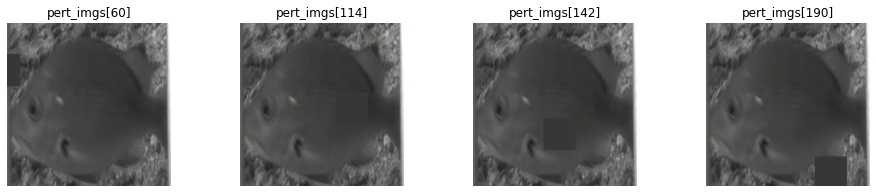

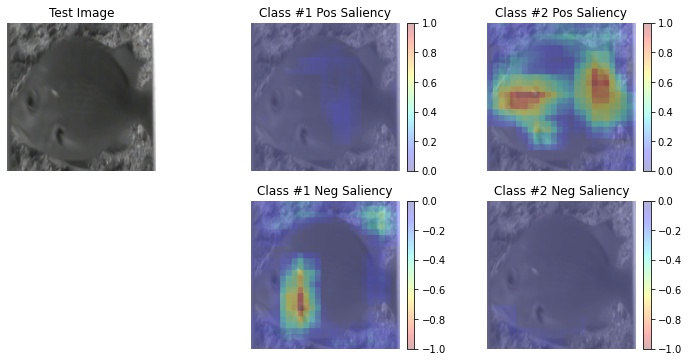

In [7]:
app(
    test_image_filename,
    blackbox_classifier,
    perturber_slidingwindow,
    sal_map_generator,
    fill=blackbox_fill,
)

Perterbation masks: (1000, 256, 256)
Perterbed images: 1000
Visualizing 4 random perturbed images...
clf predict 1/1... rate=28.44 Hz, eta=0:00:00, total=0:00:00
Ref preds: (2,)
clf predict 250/250... rate=32.57 Hz, eta=0:00:00, total=0:00:07
Pert preds: (1000, 2)
Saliency maps: (2, 256, 256)
Class 0 saliency map range: [-1.0, -0.3755798041820526]
Class 1 saliency map range: [0.8846594095230103, 1.0]


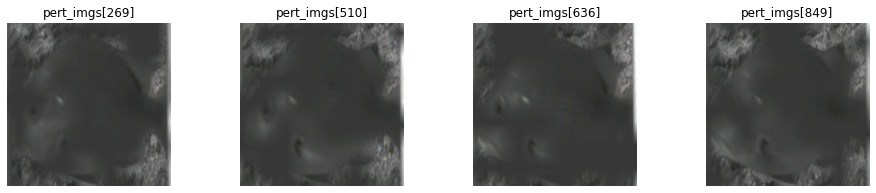

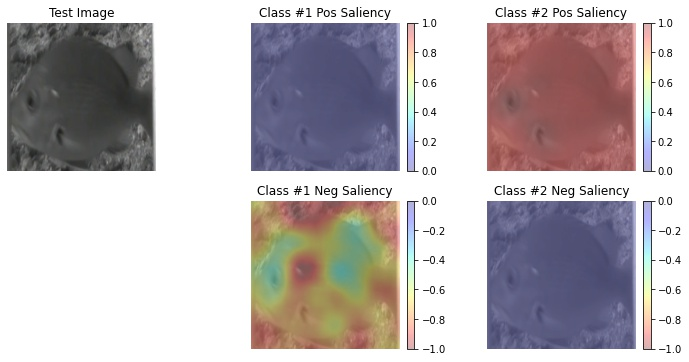

In [8]:
app(
    test_image_filename,
    blackbox_classifier,
    perturber_rise,  # The change
    sal_map_generator,
    fill=blackbox_fill,
)